## For the Telco Customer Churn
- train Deep Neural Network and report the performance. 
- Perform a Grid Search and report the best-performing hyperparameters.  

<i> Report the performance includes: Performance Metrics (Accuracy, Precision, Recall, F-1 score), confusion matrices, and loss curve. You need to train the model to achieve satisfactory results in all 4 performance metrics. For example, a higher accuracy but poor F-1 score for a model is not acceptable. </i>

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [22]:
#read data
data_path = "WA_Fn-UseC_-Telco-Customer-Churn.csv"
data = pd.read_csv(data_path)
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [24]:
data = data.drop(["customerID"], axis=1)  

# Converting float-like "object" data to "float" data
feature_column = data.pop("TotalCharges")
feature_column = feature_column.str.strip()
feature_column = feature_column.replace(['', 'non_numeric_value'], np.nan)
feature_column = pd.to_numeric(feature_column, errors='coerce')

data["TotalCharges"] = feature_column


In [25]:

# Automatically identify categorical columns
target = data.pop("Churn")
target = target.replace({"No": 0, "Yes": 1})

categorical_cols = data.select_dtypes(include=['object']).columns

print(categorical_cols)

# Encoding all the unique values
encoded_data = data.apply(LabelEncoder().fit_transform)
encoded_data = encoded_data.map(lambda x: x.strip() if isinstance(x, str) else x)
encoded_data = encoded_data.replace(['', 'non_numeric_value'], np.nan)
encoded_data = encoded_data.astype(float)
encoded_data["Churn"] = target

encoded_data.head()

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')


C:\Users\SRTU\AppData\Local\Temp\ipykernel_12752\1178526568.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target = target.replace({"No": 0, "Yes": 1})


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,142.0,74.0,0
1,1.0,0.0,0.0,0.0,34.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,3.0,498.0,3624.0,0
2,1.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,436.0,536.0,1
3,1.0,0.0,0.0,0.0,45.0,0.0,1.0,0.0,2.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,266.0,3570.0,0
4,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,729.0,674.0,1


In [26]:
encoded_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   float64
 1   SeniorCitizen     7043 non-null   float64
 2   Partner           7043 non-null   float64
 3   Dependents        7043 non-null   float64
 4   tenure            7043 non-null   float64
 5   PhoneService      7043 non-null   float64
 6   MultipleLines     7043 non-null   float64
 7   InternetService   7043 non-null   float64
 8   OnlineSecurity    7043 non-null   float64
 9   OnlineBackup      7043 non-null   float64
 10  DeviceProtection  7043 non-null   float64
 11  TechSupport       7043 non-null   float64
 12  StreamingTV       7043 non-null   float64
 13  StreamingMovies   7043 non-null   float64
 14  Contract          7043 non-null   float64
 15  PaperlessBilling  7043 non-null   float64
 16  PaymentMethod     7043 non-null   float64


In [27]:
x = encoded_data.drop("Churn", axis=1)
y = encoded_data["Churn"]

In [28]:
#scaling the data
columns_to_scale = ['tenure', 'TotalCharges', 'MonthlyCharges', ]

scaler = StandardScaler()
x[columns_to_scale] = scaler.fit_transform(x[columns_to_scale])
#x_scaled = scaler.fit_transform(x)

In [29]:
from sklearn.model_selection import train_test_split
x_train_full, x_test, y_train_full, y_test = train_test_split(x, y, test_size=0.2, random_state=33)
print(x_train_full.shape)
input_dim = x_train_full.shape[1]
input_dim


(5634, 19)


19

In [30]:
x_train, x_valid = x_train_full[:5000], x_train_full[5000:]
y_train, y_valid = y_train_full[:5000], y_train_full[5000:]

In [31]:

from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y)
# Define classes and compute weights
class_weights = compute_class_weight('balanced', classes=classes, y=y)
class_weights_dict = dict(enumerate(class_weights))

print(class_weights_dict)

{0: 0.6806146115191342, 1: 1.8841626538255751}


In [32]:
model = keras.models.Sequential(
    [
        keras.layers.Input(shape=(input_dim,)),
        keras.layers.Dense(units=500, activation="relu"),
        keras.layers.Dropout(.33),
        keras.layers.Dense(units=300, activation="relu"),
        keras.layers.Dropout(.33),
        keras.layers.Dense(units=100, activation="relu"),
        keras.layers.Dense(units=1, activation="sigmoid")
    ]
)

In [33]:
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 500)            │        10,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 300)            │       150,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 190,501 (744.14 KB)

 Trainable params: 190,501 (744.14 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
model.compile(loss="binary_crossentropy", optimizer="sgd", metrics=["accuracy"])

In [35]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

model.fit(x_train_resampled, y_train_resampled, 
          epochs=30, 
          batch_size=32, 
          validation_data=(x_valid, y_valid))

Epoch 1/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5985 - loss: 0.6593 - val_accuracy: 0.7319 - val_loss: 0.5334
Epoch 2/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7541 - loss: 0.5235 - val_accuracy: 0.7666 - val_loss: 0.4750
Epoch 3/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7693 - loss: 0.4994 - val_accuracy: 0.7508 - val_loss: 0.4857
Epoch 4/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7671 - loss: 0.4882 - val_accuracy: 0.7429 - val_loss: 0.4937
Epoch 5/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7804 - loss: 0.4765 - val_accuracy: 0.7287 - val_loss: 0.5054
Epoch 6/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7765 - loss: 0.4806 - val_accuracy: 0.7382 - val_loss: 0.4935
Epoch 7/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7695 - loss: 0.4842 - val_accuracy: 0.7413 - val_loss: 0.4928
Epoch 8/30
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7638 - loss: 0.4835 - val_accuracy: 0.

In [36]:
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [37]:
result = model.evaluate(x_test, y_test)
print("The Accuracy score on the Train set is:\t{:0.3f}".format(result[1]))

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - accuracy: 0.7443 - loss: 0.5070
The Accuracy score on the Train set is:	0.735


In [38]:
#evaluation

from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.72      0.80      1026
           1       0.51      0.77      0.61       383

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.79      0.74      0.75      1409



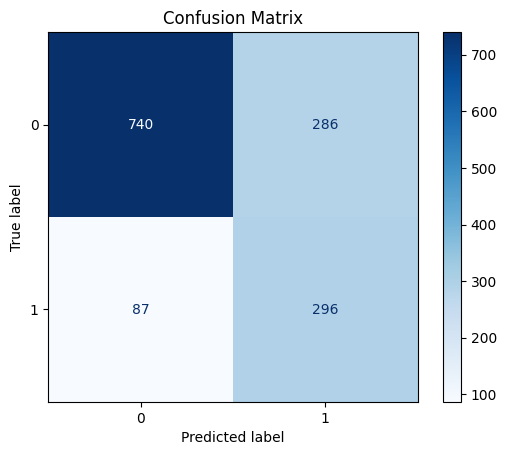

In [39]:
# Compute the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Grid Search

In [40]:
# Function to create the DNN model
def create_dnn_model(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # Sigmoid for binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

#  Grid Search for Deep Neural Network
dnn_param_grid = {
    'batch_size': [32, 64],
    'epochs': [10, 20],
    'verbose': [1],
}

dnn_model = KerasClassifier(build_fn=create_dnn_model, input_dim=x_train.shape[1], epochs=10, batch_size=32)
dnn_grid_search = GridSearchCV(dnn_model, dnn_param_grid, cv=5, verbose=1)
dnn_grid_search.fit(x_train, y_train)
print(f"DNN Best Parameters: {dnn_grid_search.best_params_}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Epoch 1/10


c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6794 - loss: 0.5553
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7981 - loss: 0.4284
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7860 - loss: 0.4349
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7871 - loss: 0.4389
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7979 - loss: 0.4220
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8071 - loss: 0.4117
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8034 - loss: 0.4200
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8006 - loss: 0.4112
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8093 - loss: 0.4015
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8018 - loss: 0.4077
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7471 - loss: 0.5238
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7685 - loss: 0.4495
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7840 - loss: 0.4242
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7912 - loss: 0.4261
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8115 - loss: 0.4119
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7959 - loss: 0.4198
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7887 - loss: 0.4342
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8133 - loss: 0.4008
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7944 - loss: 0.4120
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7987 - loss: 0.4274
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6735 - loss: 0.5666
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7845 - loss: 0.4594
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7730 - loss: 0.4327
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8034 - loss: 0.4221
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7933 - loss: 0.4235
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7771 - loss: 0.4345
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7978 - loss: 0.4099
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7929 - loss: 0.4299
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7959 - loss: 0.4166
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7863 - loss: 0.4249
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6549 - loss: 0.5867
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7914 - loss: 0.4534
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8128 - loss: 0.4047
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8030 - loss: 0.4261
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7927 - loss: 0.4217
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8005 - loss: 0.4268
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7990 - loss: 0.4339
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8056 - loss: 0.4051
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8118 - loss: 0.4017
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8072 - loss: 0.4171
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/10


c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7578 - loss: 0.4961
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7851 - loss: 0.4333
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7875 - loss: 0.4272
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - accuracy: 0.7922 - loss: 0.4278
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7981 - loss: 0.4207
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8136 - loss: 0.4010
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8081 - loss: 0.3962  
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - accuracy: 0.8119 - loss: 0.4006
Epoch 9/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.8147 - loss: 0.3951
Epoch 10/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8137 - loss: 0.3995  
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/20


c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7148 - loss: 0.5347
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7891 - loss: 0.4288
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7975 - loss: 0.4174
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - accuracy: 0.7910 - loss: 0.4222
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - accuracy: 0.8072 - loss: 0.4240
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - accuracy: 0.8030 - loss: 0.4136
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - accuracy: 0.8053 - loss: 0.4147
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - accuracy: 0.8163 - loss: 0.4121
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - accuracy: 0.8053 - loss: 0.4110
Epoch 10/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8035 - loss: 0.4056
Epoch 11/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8243 - loss: 0.3904  
Epoch 12/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/s

c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6982 - loss: 0.5726
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7840 - loss: 0.4424
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8028 - loss: 0.4242
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7892 - loss: 0.4311
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8020 - loss: 0.4222
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7985 - loss: 0.4207
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8084 - loss: 0.4150
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8025 - loss: 0.4148
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8102 - loss: 0.4015
Epoch 10/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7980 - loss: 0.4041
Epoch 11/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8100 - loss: 0.4078
Epoch 12/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7477 - loss: 0.5071
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7856 - loss: 0.4381
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7801 - loss: 0.4383
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7911 - loss: 0.4226
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7784 - loss: 0.4367
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7975 - loss: 0.4163
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8047 - loss: 0.4124
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7882 - loss: 0.4182
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7979 - loss: 0.4134
Epoch 10/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8030 - loss: 0.4197
Epoch 11/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8022 - loss: 0.4078
Epoch 12/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7465 - loss: 0.5081
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7899 - loss: 0.4412
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7858 - loss: 0.4445
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7964 - loss: 0.4303
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8005 - loss: 0.4190
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7967 - loss: 0.4198
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8050 - loss: 0.4199
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7901 - loss: 0.4199
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8003 - loss: 0.4132
Epoch 10/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8120 - loss: 0.4014
Epoch 11/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8137 - loss: 0.4039
Epoch 12/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7267 - loss: 0.5227
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8023 - loss: 0.4187
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8084 - loss: 0.4104
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7935 - loss: 0.4238
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7997 - loss: 0.4222
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8001 - loss: 0.4105
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7949 - loss: 0.4256
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8111 - loss: 0.3989
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8120 - loss: 0.4186
Epoch 10/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8121 - loss: 0.4016
Epoch 11/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8169 - loss: 0.4191
Epoch 12/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy

c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7388 - loss: 0.5188
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7903 - loss: 0.4334
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7971 - loss: 0.4224
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7962 - loss: 0.4229
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7967 - loss: 0.4155
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8068 - loss: 0.4139
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8078 - loss: 0.4045
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8047 - loss: 0.4058
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8089 - loss: 0.3926
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7939 - loss: 0.4249
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7056 - loss: 0.5601
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7700 - loss: 0.4541
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7810 - loss: 0.4369
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7932 - loss: 0.4198
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7896 - loss: 0.4334
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8035 - loss: 0.4166
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7963 - loss: 0.4267
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8057 - loss: 0.4129
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7924 - loss: 0.4133
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7997 - loss: 0.4288
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/10


c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6605 - loss: 0.5863
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7812 - loss: 0.4468
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7917 - loss: 0.4358
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7877 - loss: 0.4330
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7897 - loss: 0.4254
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8027 - loss: 0.4157
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7994 - loss: 0.4158
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7969 - loss: 0.4209
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8046 - loss: 0.4205
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7959 - loss: 0.4205
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6892 - loss: 0.5827
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8030 - loss: 0.4346
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7964 - loss: 0.4213
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7975 - loss: 0.4196
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7987 - loss: 0.4352
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7892 - loss: 0.4363
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7965 - loss: 0.4185
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8128 - loss: 0.4083
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7949 - loss: 0.4239
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8045 - loss: 0.4193
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7498 - loss: 0.5009
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7752 - loss: 0.4391
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7992 - loss: 0.4214
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7960 - loss: 0.4306
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8039 - loss: 0.4005
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8036 - loss: 0.4193
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7923 - loss: 0.4183
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8061 - loss: 0.4096
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8064 - loss: 0.4119
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8089 - loss: 0.4103
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/20


c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6768 - loss: 0.5741
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7878 - loss: 0.4520
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7963 - loss: 0.4216
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8012 - loss: 0.4347
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8025 - loss: 0.4220
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8159 - loss: 0.4030
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8029 - loss: 0.4078
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8172 - loss: 0.3994
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8057 - loss: 0.4026
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7993 - loss: 0.4173
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8122 - loss: 0.4004
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8007 - loss: 0.4062


c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7510 - loss: 0.5086
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7859 - loss: 0.4386
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8033 - loss: 0.4242
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8031 - loss: 0.4184
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7926 - loss: 0.4266
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7960 - loss: 0.4227
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7976 - loss: 0.4232
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8034 - loss: 0.4123
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8009 - loss: 0.4136
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8073 - loss: 0.4038
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7995 - loss: 0.4065
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8046 - loss: 0.4001


c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7228 - loss: 0.5432
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7696 - loss: 0.4471
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7802 - loss: 0.4354
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7924 - loss: 0.4388
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7875 - loss: 0.4266
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7916 - loss: 0.4250
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8008 - loss: 0.4133
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7878 - loss: 0.4250
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7850 - loss: 0.4234
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7988 - loss: 0.4161
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8001 - loss: 0.4077
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8054 - loss: 0.4091


c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7071 - loss: 0.5699
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7835 - loss: 0.4475
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7978 - loss: 0.4342
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8023 - loss: 0.4230
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7995 - loss: 0.4220
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7929 - loss: 0.4322
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8094 - loss: 0.4143
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8000 - loss: 0.4201
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8006 - loss: 0.4230
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8034 - loss: 0.4189
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8071 - loss: 0.4183
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8120 - loss: 0.3920


c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7346 - loss: 0.5466
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7778 - loss: 0.4418
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7866 - loss: 0.4423
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7971 - loss: 0.4198
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8057 - loss: 0.4254
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8010 - loss: 0.4141
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8014 - loss: 0.4095
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8100 - loss: 0.4037
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8151 - loss: 0.3914
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8146 - loss: 0.3997
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8168 - loss: 0.3990
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8032 - loss: 0.4229


c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\SRTU\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6635 - loss: 0.5743
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7871 - loss: 0.4410
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8073 - loss: 0.4194
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7862 - loss: 0.4389
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7997 - loss: 0.4110
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8071 - loss: 0.4094
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8057 - loss: 0.4130
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8061 - loss: 0.4102
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8064 - loss: 0.4146
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7980 - loss: 0.4145
DNN Best Parameters: {'batch_size': 32, 'epochs': 10, 'verbose': 1}
